In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import scipy
%matplotlib inline


In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\shubh\anaconda3\envs\tf-gpu\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
import zipfile
z=zipfile.ZipFile("data.zip")
z.extractall()

In [4]:
dataset_path = 'Potato/Train/'
# Categories for classification
categories = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

train_data = []
labels = []
img_size = 256

for category in categories:
    path = os.path.join(dataset_path, category)
    class_num = categories.index(category) 
    count=1
    for img in os.listdir(path):
        try:
            source=path+img
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (img_size, img_size))
            
            train_data.append(img_array)
            labels.append(class_num)
        except Exception as e:
            print(f"Error loading image: {e}")



In [5]:
dataset_path = 'Potato/Test/'
# Categories for classification
categories = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

test_data = []
labels = []
img_size = 256

for category in categories:
    path = os.path.join(dataset_path, category)
    class_num = categories.index(category) 
    count=1
    for img in os.listdir(path):
        try:
            source=path+img
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (img_size, img_size))
            
            test_data.append(img_array)
            labels.append(class_num)
        except Exception as e:
            print(f"Error loading image: {e}")

In [6]:
dataset_path = 'Potato/Valid/'
# Categories for classification
categories = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

valid_data = []
labels = []
img_size = 256

for category in categories:
    path = os.path.join(dataset_path, category)
    class_num = categories.index(category) 
    count=1
    for img in os.listdir(path):
        try:
            source=path+img
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (img_size, img_size))
            
            valid_data.append(img_array)
            labels.append(class_num)
        except Exception as e:
            print(f"Error loading image: {e}")

## Exploratry Data Analysis

In [7]:
# Convert lists to numpy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)
valid_data = np.array(valid_data)


labels = np.array(labels)

print("Dataset loaded successfully!")
print(f"Number of train images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of valid images: {len(valid_data)}")


Dataset loaded successfully!
Number of train images: 900
Number of test images: 300
Number of valid images: 300


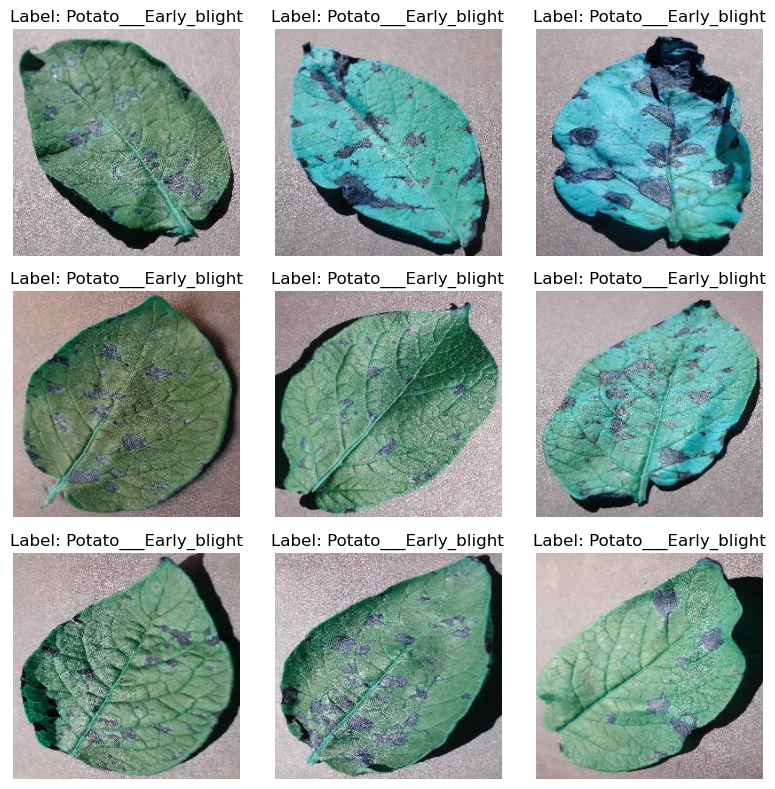

In [18]:

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[i])
    plt.title(f"Label: {categories[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
# One-hot encoding the labels
labels = to_categorical(labels, num_classes=3)

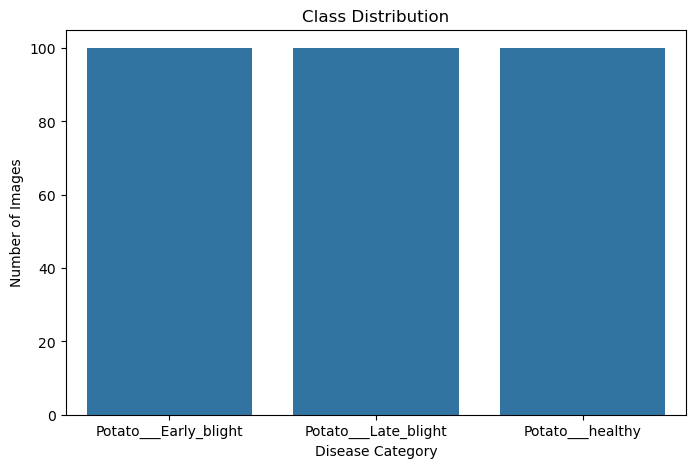

In [20]:
class_distribution = {category: sum(labels[:, i]) for i, category in enumerate(categories)}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title("Class Distribution")
plt.xlabel("Disease Category")
plt.ylabel("Number of Images")
plt.show()


In [9]:
# Checking if all images have the same shape
shapes = [img.shape for img in train_data]
unique_shapes = set(shapes)
print(f"Unique image shapes in the dataset: {unique_shapes}")


Unique image shapes in the dataset: {(256, 256, 3)}


## Data Augmentation and Preparation

In [23]:
train_data.shape

(900, 256, 256, 3)

In [10]:
train_datagen=ImageDataGenerator(
                   rescale=1./255,
                   horizontal_flip=0.3,
                   vertical_flip=0.3,
                   rotation_range=36,
                   shear_range=0.2,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   fill_mode="nearest"
                  )

validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    'Potato/Train/',  
    target_size=(256, 256), 
    batch_size=32, 
    class_mode='categorical' ,
    color_mode="rgb"
)

validation_generator= validation_datagen.flow_from_directory(
            directory= 'Potato/Valid/',
            target_size= (256,256),
            batch_size= 32,
            class_mode= 'categorical',
            color_mode="rgb")

test_generator = test_datagen.flow_from_directory(
        directory='Potato/Test/',
        target_size = (256, 256),
        batch_size = 32,
        class_mode = 'categorical',
        color_mode = "rgb",
        shuffle=False  
)

Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


## Model Building

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import models, layers,Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
model = models.Sequential([
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [275]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [19]:
es= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint('best_potato_leaf_model.h5', save_best_only=True)

In [93]:
history = model.fit(
    train_generator,  
    validation_data=validation_generator, 
    epochs=27,                   
    callbacks=[es, mc]          
)

Epoch 1/27
29/29 [==============================] - 24s 795ms/step - loss: 1.0852 - accuracy: 0.4000 - val_loss: 1.0090 - val_accuracy: 0.5567
Epoch 2/27
29/29 [==============================] - 24s 806ms/step - loss: 0.6831 - accuracy: 0.6989 - val_loss: 0.4900 - val_accuracy: 0.7600
Epoch 3/27
29/29 [==============================] - 24s 806ms/step - loss: 0.4683 - accuracy: 0.8156 - val_loss: 0.5351 - val_accuracy: 0.7333
Epoch 4/27
29/29 [==============================] - 23s 795ms/step - loss: 0.4206 - accuracy: 0.8211 - val_loss: 0.4251 - val_accuracy: 0.8033
Epoch 5/27
29/29 [==============================] - 24s 809ms/step - loss: 0.3638 - accuracy: 0.8633 - val_loss: 0.3963 - val_accuracy: 0.8500
Epoch 6/27
29/29 [==============================] - 24s 806ms/step - loss: 0.3434 - accuracy: 0.8533 - val_loss: 0.3111 - val_accuracy: 0.8767
Epoch 7/27
29/29 [==============================] - 23s 794ms/step - loss: 0.3352 - accuracy: 0.8778 - val_loss: 0.3351 - val_accuracy: 0.8533

In [279]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model.save("model_weights/custom_model.h5")
print("Model saved succesfully")

Model saved succesfully


## Model Evaluation

In [104]:
model.load_weights('model_weights/custom_model.h5')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


# Generate a classification report
y_pred = np.argmax(model.predict(test_generator), axis=1)

10/10 [==============================] - 1s 54ms/step - loss: 0.1597 - accuracy: 0.9567
Test Accuracy: 95.67%
10/10 [==============================] - 1s 62ms/step


In [105]:
# Get true labels from the test generator
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=class_labels))

                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.92      0.95       100
 Potato___Late_blight       0.92      0.95      0.94       100
     Potato___healthy       0.96      1.00      0.98       100

             accuracy                           0.96       300
            macro avg       0.96      0.96      0.96       300
         weighted avg       0.96      0.96      0.96       300



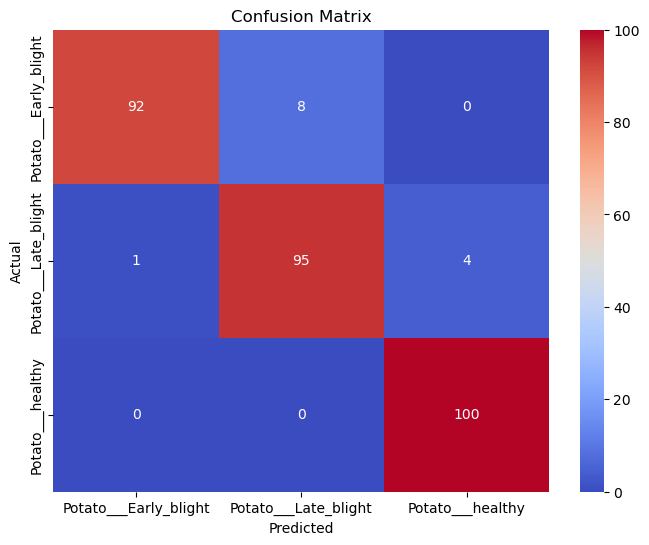

In [117]:
#Visualize Confussion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
# sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

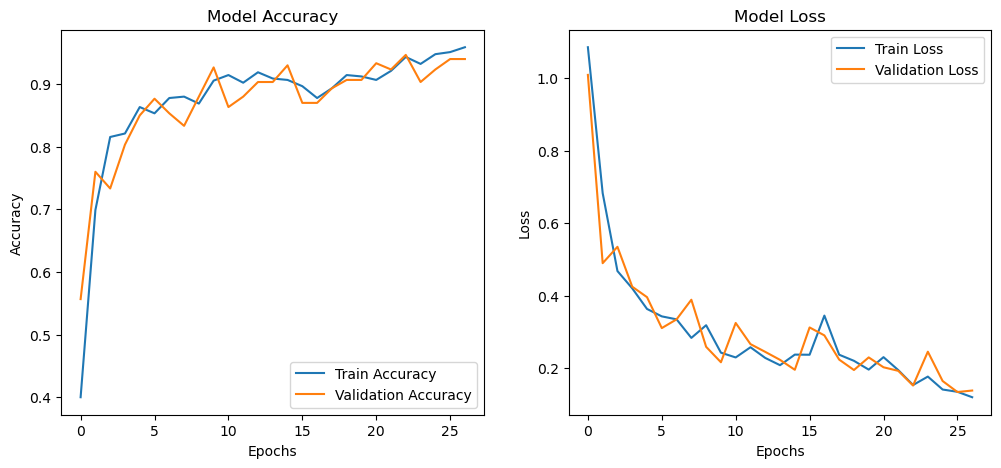

In [111]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


10/10 [==============================] - 1s 74ms/step


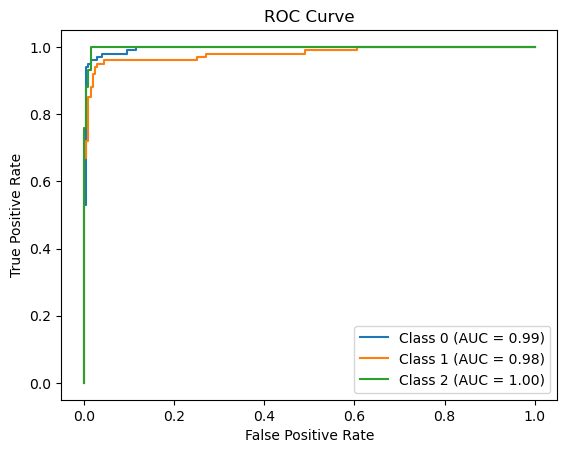

In [123]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

num_classes = 3  

y_true = test_generator.classes  

y_test_bin = label_binarize(y_true, classes=[0, 1, 2])  
y_score = model.predict(test_generator)

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## GradCam

In [138]:
from tensorflow.keras.preprocessing import image

In [184]:
def generate_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = np.argmax(predictions[0])  # Predicted class index
        loss = predictions[:, predicted_class]

    # Calculate gradients of the loss w.r.t. the feature maps
    gradients = tape.gradient(loss, conv_outputs)
    
    # Compute the importance of each channel
    pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))
    
    # Apply the pooled gradients to the feature maps
    conv_outputs = conv_outputs[0]
    heatmap = np.zeros(conv_outputs.shape[:-1])

    for i in range(conv_outputs.shape[-1]):
        heatmap += pooled_gradients[i] * conv_outputs[:, :, i]

    # Apply ReLU to focus on positive influence only
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap for visualization
    heatmap /= np.max(heatmap)
    return heatmap

    

In [185]:
def preprocess_image(img_path, img_size=(256, 256)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image
    return img_array


In [192]:
model.load_weights('model_weights/custom_model.h5')

img_path = 'Potato/Valid/Potato___Early_blight/a0d8a499-e9e4-4c88-829c-7c2270073735___RS_Early.B 8525.jpg'  
img_array = preprocess_image(img_path)
heatmap = generate_grad_cam(model, img_array, layer_name='conv2d_29')


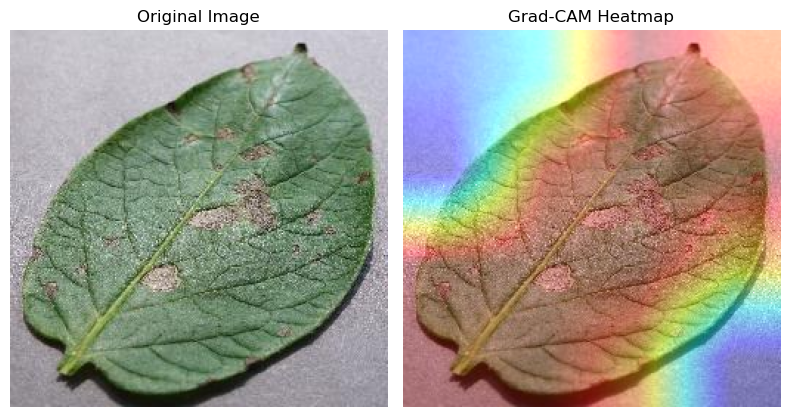

In [201]:
def display_grad_cam(img_path, heatmap):
    # Read the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    
    # Resize the heatmap to the size of the original image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize and apply a color map to the heatmap
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.8, heatmap_resized, 0.4, 0)

    # Plot both the original image and the superimposed heatmap side by side
    plt.figure(figsize=(8, 6))
    
    # Original image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Superimposed heatmap on the right
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_grad_cam(img_path, heatmap)


## MobileNetV2

In [45]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


87910968/87910968 [==============================] - 8s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 127, 127, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_23[0][0]']              
 alization)                

In [49]:
history2 = model.fit(
    train_generator,  
    validation_data=validation_generator, 
    epochs=5,                   
    callbacks=[es, mc]          
) 

Epoch 1/5
29/29 [==============================] - 25s 850ms/step - loss: 0.1158 - accuracy: 0.9522 - val_loss: 0.1938 - val_accuracy: 0.9233
Epoch 2/5
29/29 [==============================] - 25s 849ms/step - loss: 0.1028 - accuracy: 0.9678 - val_loss: 0.2258 - val_accuracy: 0.9167
Epoch 3/5
29/29 [==============================] - 24s 834ms/step - loss: 0.1114 - accuracy: 0.9633 - val_loss: 0.2107 - val_accuracy: 0.9300
Epoch 4/5
29/29 [==============================] - 25s 864ms/step - loss: 0.1241 - accuracy: 0.9556 - val_loss: 0.1461 - val_accuracy: 0.9367
Epoch 5/5
29/29 [==============================] - 25s 841ms/step - loss: 0.0926 - accuracy: 0.9611 - val_loss: 0.1666 - val_accuracy: 0.9533


In [50]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model.save("model_weights/Inception.h5")
print("Model saved succesfully")

Model saved succesfully


In [51]:
model.load_weights('model_weights/Inception.h5')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


# Generate a classification report
y_pred = np.argmax(model.predict(test_generator), axis=1)

10/10 [==============================] - 2s 145ms/step - loss: 0.1561 - accuracy: 0.9533
Test Accuracy: 95.33%
10/10 [==============================] - 2s 149ms/step


In [28]:
# Get true labels from the test generator
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=class_labels))

                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.99      0.99       100
 Potato___Late_blight       0.97      0.98      0.98       100
     Potato___healthy       1.00      0.98      0.99       100

             accuracy                           0.98       300
            macro avg       0.98      0.98      0.98       300
         weighted avg       0.98      0.98      0.98       300



## ResNet50

In [284]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [233]:
history2 = model.fit(
    train_generator,  
    validation_data=validation_generator, 
    epochs=5,                   
    callbacks=[es, mc]          
)

Epoch 1/5
29/29 [==============================] - 43s 1s/step - loss: 1.1161 - accuracy: 0.3700 - val_loss: 1.0683 - val_accuracy: 0.3467
Epoch 2/5
29/29 [==============================] - 34s 1s/step - loss: 1.0631 - accuracy: 0.4467 - val_loss: 1.0185 - val_accuracy: 0.4900
Epoch 3/5
29/29 [==============================] - 33s 1s/step - loss: 1.0372 - accuracy: 0.4433 - val_loss: 0.9703 - val_accuracy: 0.5467
Epoch 4/5
29/29 [==============================] - 35s 1s/step - loss: 1.0030 - accuracy: 0.4800 - val_loss: 0.9390 - val_accuracy: 0.5500
Epoch 5/5
29/29 [==============================] - 35s 1s/step - loss: 0.9928 - accuracy: 0.4844 - val_loss: 0.9084 - val_accuracy: 0.6100


In [246]:
for layer in base_model.layers[-20:]: #fine tunning
    layer.trainable = True

model.compile(Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [247]:
history3 = model.fit(
    train_generator,  
    validation_data=validation_generator, 
    epochs=20,                   
    callbacks=[es, mc]          
)

Epoch 1/20
29/29 [==============================] - 31s 926ms/step - loss: 0.2918 - accuracy: 0.8900 - val_loss: 0.4545 - val_accuracy: 0.8033
Epoch 2/20
29/29 [==============================] - 25s 870ms/step - loss: 0.2759 - accuracy: 0.9022 - val_loss: 0.5856 - val_accuracy: 0.7600
Epoch 3/20
29/29 [==============================] - 25s 861ms/step - loss: 0.2729 - accuracy: 0.8956 - val_loss: 0.4583 - val_accuracy: 0.8100
Epoch 4/20
29/29 [==============================] - 25s 871ms/step - loss: 0.2570 - accuracy: 0.9100 - val_loss: 0.4531 - val_accuracy: 0.7933
Epoch 5/20
29/29 [==============================] - 25s 866ms/step - loss: 0.2497 - accuracy: 0.9133 - val_loss: 0.4920 - val_accuracy: 0.7833
Epoch 6/20
29/29 [==============================] - 25s 857ms/step - loss: 0.2572 - accuracy: 0.9033 - val_loss: 0.2970 - val_accuracy: 0.8733
Epoch 7/20
29/29 [==============================] - 23s 779ms/step - loss: 0.2660 - accuracy: 0.9044 - val_loss: 0.4469 - val_accuracy: 0.8167

In [286]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model.save("model_weights/ResNet.h5")
print("Model saved succesfully")

Model saved succesfully


In [285]:
model.load_weights('model_weights/ResNet.h5')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


# Generate a classification report
y_pred = np.argmax(model.predict(test_generator), axis=1)

10/10 [==============================] - 6s 235ms/step - loss: 0.3448 - accuracy: 0.8800
Test Accuracy: 88.00%
10/10 [==============================] - 4s 247ms/step


In [257]:
# Get true labels from the test generator
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=class_labels))

                       precision    recall  f1-score   support

Potato___Early_blight       0.90      0.97      0.93       100
 Potato___Late_blight       0.79      0.91      0.85       100
     Potato___healthy       0.99      0.76      0.86       100

             accuracy                           0.88       300
            macro avg       0.89      0.88      0.88       300
         weighted avg       0.89      0.88      0.88       300



In [52]:
'''Although Accuracy of third model not very good but we have three models 
1. Custom Model -> Custom architecture
2. Inception-> Use of pretrained model
3. ResNet 50 ->Fine tunning of pretrained model'''

'Although Accuracy of third model not very good but we have three models \n1. Custom Model -> Custom architecture\n2. Inception-> Use of pretrained model\n3. ResNet 50 ->Fine tunning of pretrained model'

## Testing with image

In [265]:
filepath = 'Potato/Valid/Potato___Late_blight/a0c129b8-4fb3-406d-b2f6-1309fec50c70___RS_LB 5139.jpg'  
img_array = preprocess_image(filepath)

prediction = model.predict(img_array)
class_index = np.argmax(prediction)
class_names = ["Early Blight","Healthy", "Late Blight"]
result = class_names[class_index]
print("ResNet:",result,class_index)

1/1 [==============================] - 0s 34ms/step
ResNet: Early Blight 1


In [273]:
prediction = model.predict(img_array)
class_index = np.argmax(prediction)
class_names = ["Healthy", "Early Blight", "Late Blight"]
result = class_names[class_index]
print("MobileNet:",result,class_index)

1/1 [==============================] - 1s 840ms/step
MobileNet: Early Blight 1


In [277]:
model.load_weights("model_weights/custom_model.h5")
prediction = model.predict(img_array)
class_index = np.argmax(prediction)
class_names = ["Healthy", "Early Blight", "Late Blight"]
result = class_names[class_index]
print("MobileNet:",result,class_index)

1/1 [==============================] - 0s 120ms/step
MobileNet: Early Blight 1


**Now lets use them for deploying on both a flask app and streamlit**

In [278]:
model.load_weights("model_weights/custom_model.h5")